In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F   # adds some efficiency
from torch.utils.data import DataLoader   # allows loading data in batches
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### PyTorch makes the MNIST dataset availabel via torchvision. The first time is is called, the dataset will be downloaded noto my computer to the path specified. Then, torchvision will always look for a local copy before attempting another download

In [3]:
# Here we may need to apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the incoming data.
# In current case, we only need to convert images to tensors.

transform = transforms.ToTensor()

In [4]:
# Load the training set

train_data = datasets.MNIST(root='../Data/', train=True, download=True, transform=transform)

In [5]:
# Load the test set

test_data = datasets.MNIST(root='../Data/', train=False, download=True, transform=transform)

In [6]:
# The training set contains 60000 records. The total number of parameters trained in ANN is over 100,000 parameters.

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
# the batch_size is the number of records to be processed at a time. 
# If it is not evenly divisible into the dataset, then the final batch contains the remainder.
# When working with images, we want relatively small batches; a batch sieze of 4 is very common.
# setting shuffle to True means that the dataset will be shuffled after each epoch.

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

#### We plan to employ two convolutional layers and two pooling layers feeding data through fully connected hidden layers to the output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

In [9]:
# The first layer has one input channel (the grayscale color channel). Here assign 6 output channels for feature extraction.
# 1 color channel, 6 filters (output channels), 3 by 3 kernal, stride (step size) = 1
conv1 = nn.Conv2d(1, 6, 3, 1)  # 6 filters  --> pooling --> conv2

# 6 input filters from conv1, 16 filters as output, 3 by 3, stride = 1
conv2 = nn.Conv2d(6, 16, 3, 1)

In [10]:
# Grab the first MNIST record

for i, (X_train, y_train) in enumerate(train_data):
    break

In [14]:
# Create a rank-4 tensor to be passed into the model
# 1 batch, 1 color channel, 28 pix, 28 pix

x = X_train.view(1, 1, 28, 28)

In [16]:
# activations can be applied to the convolutions in one line using F.relu() and pooling is done using F.max_pool2d()
# Perform the first convolution/activation

x = F.relu(conv1(x))

In [17]:
# since there was no zero-padding info, the image lost part border info.
# But an MNIST iamge is mostly black at the edges, it is safe to ignore these pixels.
# After apply pooling layers twice, the output will be (((28-2)/2)-2)/2 = 5.5 which rounds down to 5 pixels per side.

x.shape

torch.Size([1, 6, 26, 26])

In [18]:
# here ran the first pooling layer, after this step, the pix info lost half.

x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape

torch.Size([1, 6, 13, 13])

In [20]:
# Perform the second convolution/activation

x = F.relu(conv2(x))

In [21]:
x.shape

torch.Size([1, 16, 11, 11])

In [22]:
# Run the second pooling layer

x = F.max_pool2d(x, 2, 2)

In [23]:
x.shape

torch.Size([1, 16, 5, 5])

In [24]:
# flatten the data for the fully connected layers.

x.view(-1, 16*5*5).shape

torch.Size([1, 400])

In [25]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [26]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
import time
start_time = time.time()

# variables(trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# for loop epochs
for i in range(epochs):

    train_corr = 0
    test_corr = 0

    # train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(train_corr)

    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes')

Epoch: 1 Batch: 600 Loss: 0.04255056381225586
Epoch: 1 Batch: 1200 Loss: 0.0794181376695633
Epoch: 1 Batch: 1800 Loss: 0.3165969252586365
Epoch: 1 Batch: 2400 Loss: 0.017571639269590378
Epoch: 1 Batch: 3000 Loss: 0.006613227538764477
Epoch: 1 Batch: 3600 Loss: 0.0016816703137010336
Epoch: 1 Batch: 4200 Loss: 0.48925676941871643
Epoch: 1 Batch: 4800 Loss: 0.021427597850561142
Epoch: 1 Batch: 5400 Loss: 0.008603979833424091
Epoch: 1 Batch: 6000 Loss: 0.026711981743574142
Epoch: 1 Batch: 600 Loss: 0.044457487761974335
Epoch: 1 Batch: 1200 Loss: 0.03015129826962948
Epoch: 1 Batch: 1800 Loss: 0.001719419495202601
Epoch: 1 Batch: 2400 Loss: 0.06534458696842194
Epoch: 1 Batch: 3000 Loss: 0.26260775327682495
Epoch: 1 Batch: 3600 Loss: 0.0007888587424531579
Epoch: 1 Batch: 4200 Loss: 0.0011536211241036654
Epoch: 1 Batch: 4800 Loss: 0.0011205750051885843
Epoch: 1 Batch: 5400 Loss: 0.0007562750251963735
Epoch: 1 Batch: 6000 Loss: 0.012275089509785175
Epoch: 1 Batch: 600 Loss: 0.001206874381750822

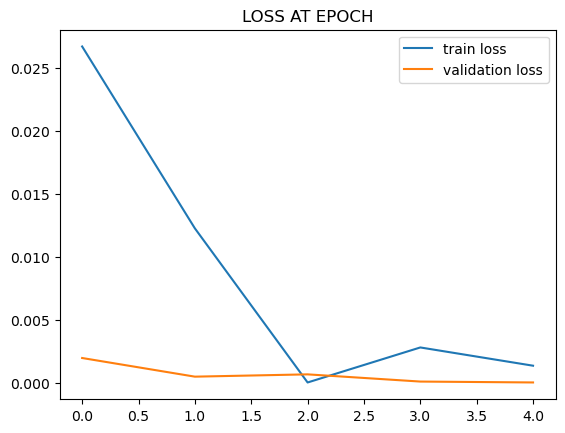

In [42]:
# Convert list of tensors to a list of NumPy arrays
train_losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
test_losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses]
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')
plt.title('LOSS AT EPOCH')
plt.legend()

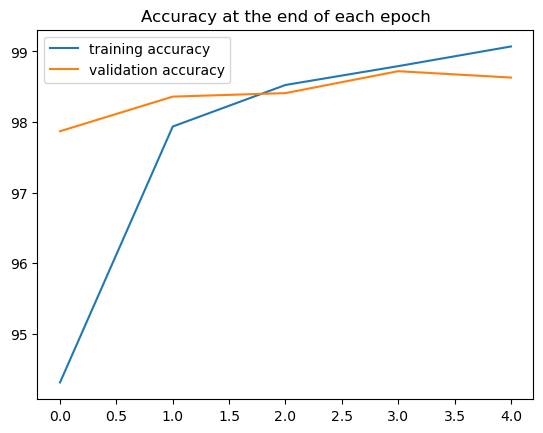

In [37]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [38]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [39]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [40]:
correct.item()/len(test_data)

0.9863